In [135]:
import os
from typing import Optional, Union
import gym
import gym.envs.registration
import gym.spaces
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

MAIN = __name__ == "__main__"
max_episode_steps = 1000
IS_CI = os.getenv("IS_CI")
N_RUNS = 200 if not IS_CI else 5

In [234]:
ObsType = int
ActType = int

class MultiArmedBandit(gym.Env):
    action_space: gym.spaces.Discrete
    observation_space: gym.spaces.Discrete
    num_arms: int
    stationary: bool
    arm_reward_means: np.ndarray
    arm_star: int

    def __init__(self, num_arms=10, stationary=True):
        super().__init__()
        self.num_arms = num_arms
        self.stationary = stationary
        self.observation_space = gym.spaces.Discrete(1)
        self.action_space = gym.spaces.Discrete(num_arms)
        self.reset()

    def step(self, arm: ActType) -> tuple[ObsType, float, bool, dict]:
        '''
        Note: some documentation references a new style which has (termination, truncation) bools in place of the done bool.
        '''
        assert self.action_space.contains(arm)
        if not self.stationary:
            q_drift = self.np_random.normal(loc=0.0, scale=0.01, size=self.num_arms)
            self.arm_reward_means += q_drift
            self.best_arm = int(np.argmax(self.arm_reward_means))
        reward = self.np_random.normal(loc=self.arm_reward_means[arm], scale=1.0)
        obs = 0
        done = False
        info = dict(best_arm=self.best_arm)
        return (obs, reward, done, info)

    def reset(
        self, seed: Optional[int] = None, return_info=False, options=None
    ) -> Union[ObsType, tuple[ObsType, dict]]:
        super().reset(seed=seed)
        if self.stationary:
            self.arm_reward_means = self.np_random.normal(loc=0.0, scale=1.0, size=self.num_arms)
        else:
            self.arm_reward_means = np.zeros(shape=[self.num_arms])
        self.best_arm = int(np.argmax(self.arm_reward_means))
        if return_info:
            return (0, dict())
        else:
            return 0

    def render(self, mode="human"):
        assert mode == "human", f"Mode {mode} not supported!"
        bandit_samples = []
        for arm in range(self.action_space.n):
            bandit_samples += [np.random.normal(loc=self.arm_reward_means[arm], scale=1.0, size=1000)]
        plt.violinplot(bandit_samples, showmeans=True)
        plt.xlabel("Bandit Arm")
        plt.ylabel("Reward Distribution")
        plt.show()

In [235]:
gym.envs.registration.register(
    id="ArmedBanditTestbed-v0",
    entry_point=MultiArmedBandit,
    max_episode_steps=max_episode_steps,
    nondeterministic=True,
    reward_threshold=1.0,
    kwargs={"num_arms": 10, "stationary": True},
)
if MAIN:
    env = gym.make("ArmedBanditTestbed-v0")
    print("Our env inside its wrappers looks like: ", env)

Our env inside its wrappers looks like:  <TimeLimit<OrderEnforcing<MultiArmedBandit<ArmedBanditTestbed-v0>>>>


/Users/josephbloom/miniforge3/envs/arena/lib/python3.10/site-packages/gym/envs/registration.py:595: UserWarning:

WARN: Overriding environment ArmedBanditTestbed-v0



In [236]:
class Agent:
    '''Base class for agents in a multi-armed bandit environment (you do not need to add any implementation here)'''

    rng: np.random.Generator

    def __init__(self, num_arms: int, seed: int):
        self.num_arms = num_arms
        self.reset(seed)

    def get_action(self) -> ActType:
        raise NotImplementedError()

    def observe(self, action: ActType, reward: float, info: dict) -> None:
        pass

    def reset(self, seed: int) -> None:
        self.rng = np.random.default_rng(seed)

def run_episode(env: gym.Env, agent: Agent, seed: int):
    (rewards, was_best) = ([], [])
    env.reset(seed=seed)
    agent.reset(seed=seed)
    done = False
    while not done:
        arm = agent.get_action()
        (obs, reward, done, info) = env.step(arm)
        agent.observe(arm, reward, info)
        rewards.append(reward)
        was_best.append(1 if arm == info["best_arm"] else 0)
    rewards = np.array(rewards, dtype=float)
    was_best = np.array(was_best, dtype=int)
    return (rewards, was_best)

def test_agent(env: gym.Env, agent: Agent, n_runs=200):
    all_rewards = []
    all_was_bests = []
    for seed in tqdm(range(n_runs)):
        (rewards, corrects) = run_episode(env, agent, seed)
        all_rewards.append(rewards)
        all_was_bests.append(corrects)
    return (np.array(all_rewards), np.array(all_was_bests))

class RandomAgent(Agent):
    def get_action(self) -> ActType:
        return self.rng.integers(low = 0, high = self.num_arms)

if MAIN:
    env = gym.make("ArmedBanditTestbed-v0")
    all_rewards, all_was_bests = test_agent(env, RandomAgent(10,202))
    print(f'mean {all_was_bests.mean()}')
    assert np.abs(all_was_bests.mean() - 0.1) < 0.01

    all_rewards, all_was_bests = test_agent(env, RandomAgent(10,2))
    print(f'mean {all_was_bests.mean()}')
    assert np.abs(all_was_bests.mean() - 0.1) < 0.01
    

  0%|          | 0/200 [00:00<?, ?it/s]

mean 0.100125


  0%|          | 0/200 [00:00<?, ?it/s]

mean 0.100125


  0%|          | 0/200 [00:00<?, ?it/s]

Frequency of correct arm: 0.698005
Average reward: 1.276473862543507


  0%|          | 0/200 [00:00<?, ?it/s]

Frequency of correct arm: 0.73572
Average reward: 1.302339059028136


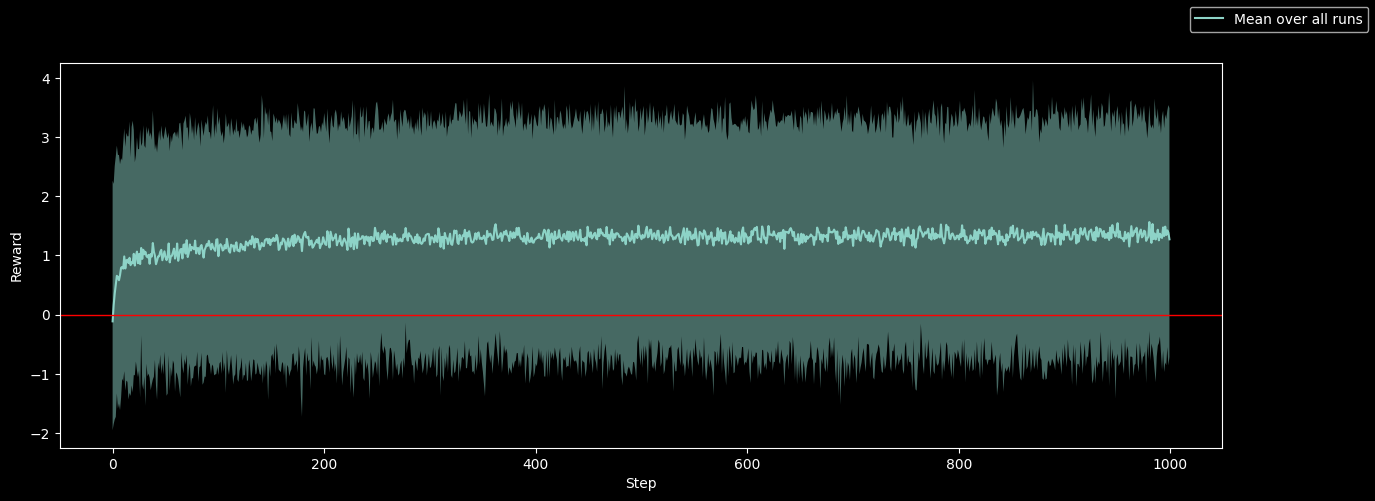

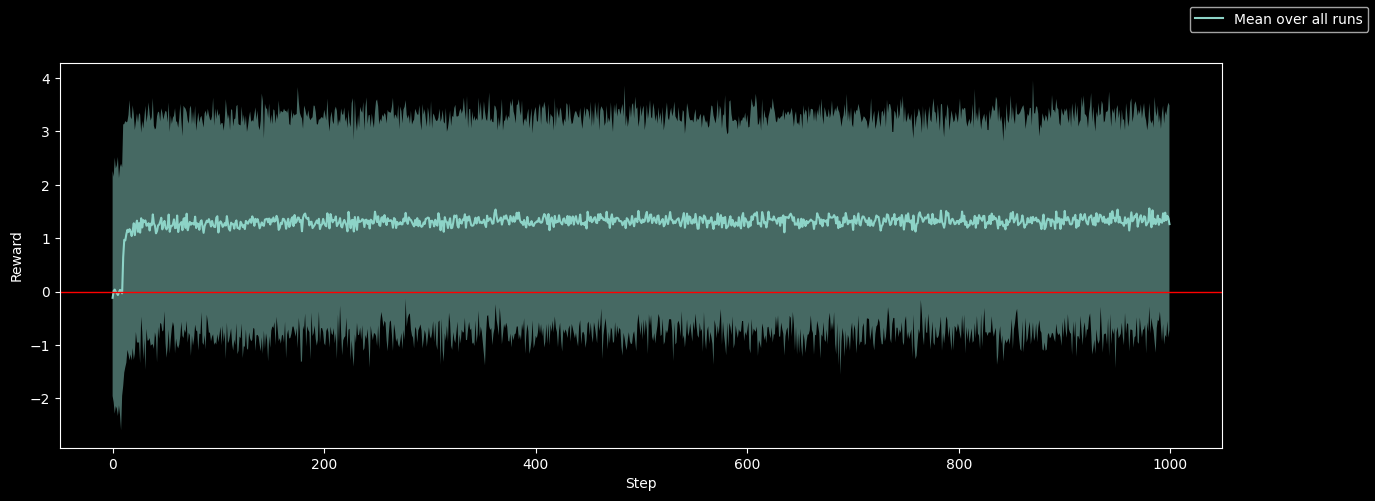

In [237]:
def plot_rewards(all_rewards: np.ndarray):
    (n_runs, n_steps) = all_rewards.shape
    (fig, ax) = plt.subplots(figsize=(15, 5))
    ax.plot(all_rewards.mean(axis=0), label="Mean over all runs")
    quantiles = np.quantile(all_rewards, [0.05, 0.95], axis=0)
    ax.fill_between(range(n_steps), quantiles[0], quantiles[1], alpha=0.5)
    ax.set(xlabel="Step", ylabel="Reward")
    ax.axhline(0, color="red", linewidth=1)
    fig.legend()
    return fig

class RewardAveraging(Agent):
    def __init__(self, num_arms: int, seed: int, epsilon: float, optimism: float):
        self.num_arms = num_arms
        self.seed = seed 
        self.epsilon = epsilon
        self.optimism = optimism
        self.rng = np.random.default_rng(seed)
        self.reward_estimates = [optimism for i in range(num_arms)]
        self.actions_taken = [1 for i in range(num_arms)]
        self.k = 1
        super().__init__(num_arms, seed)


    def get_action(self):
        pivot = self.rng.random()
        if pivot >= self.epsilon:
            return np.argmax(self.reward_estimates)
        else:
            return self.rng.integers(low = 0, high = self.num_arms)
        
    def observe(self, action, reward, info):
        times_taken_action = self.actions_taken[action]
        self.reward_estimates[action] = self.reward_estimates[action] + (1/times_taken_action)*(reward - self.reward_estimates[action])
        self.k += 1
        self.actions_taken[action] += 1

    def reset(self, seed: int) -> None:
        #self.rng = np.random.default_rng(seed)
        self.reward_estimates = [self.optimism for i in range(self.num_arms)]
        self.k = 1
        self.actions_taken = [1 for i in range(self.num_arms)]
        super().reset(seed)

if MAIN:
    num_arms = 10; stationary = True
    env = gym.make("ArmedBanditTestbed-v0", num_arms=num_arms, stationary=stationary)
    regular_reward_averaging = RewardAveraging(num_arms, 0, epsilon=0.1, optimism=0)
    (all_rewards, all_corrects) = test_agent(env, regular_reward_averaging, n_runs=N_RUNS)
    print(f"Frequency of correct arm: {all_corrects.mean()}")
    print(f"Average reward: {all_rewards.mean()}")
    fig = plot_rewards(all_rewards)
    optimistic_reward_averaging = RewardAveraging(num_arms, 0, epsilon=0.1, optimism=5)
    (all_rewards, all_corrects) = test_agent(env, optimistic_reward_averaging, n_runs=N_RUNS)
    print(f"Frequency of correct arm: {all_corrects.mean()}")
    print(f"Average reward: {all_rewards.mean()}")
    plot_rewards(all_rewards)

  0%|          | 0/200 [00:00<?, ?it/s]

Frequency of correct arm: 0.999095
Average reward: 1.5031962157960137


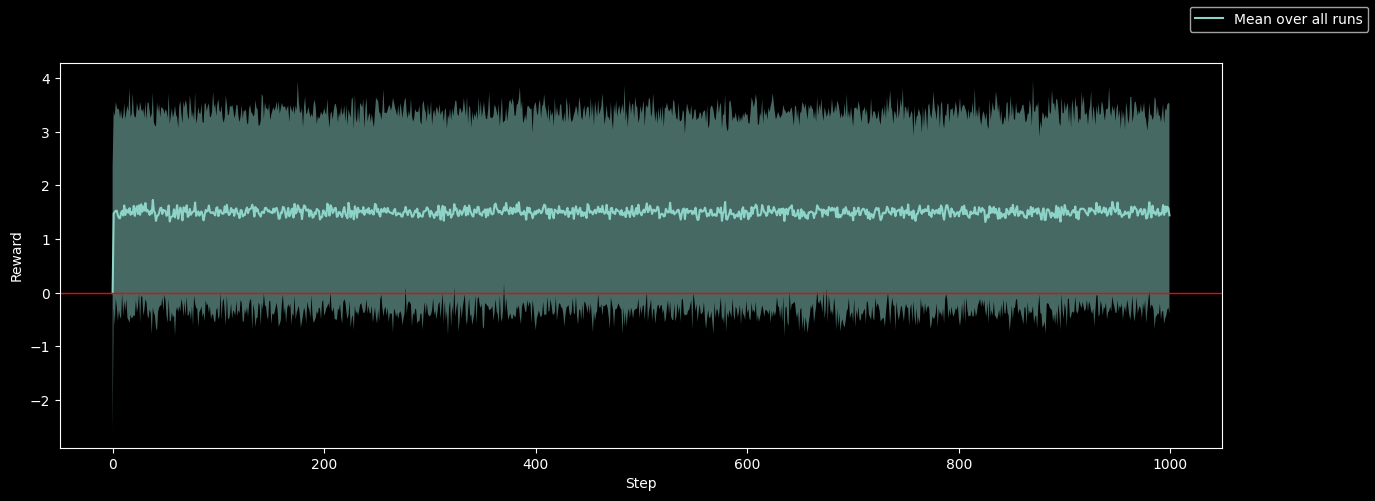

In [238]:
class CheatyMcCheater(Agent):
    def __init__(self, num_arms: int, seed: int):
        self.num_arms = num_arms
        self.seed = seed
        self.best_arm = 0

    def get_action(self):
        return self.best_arm

    def observe(self, action, reward, info):
        self.best_arm  = info["best_arm"]


if MAIN:
    cheater = CheatyMcCheater(num_arms, 0)
    (all_rewards, all_corrects) = test_agent(env, cheater, n_runs=N_RUNS)
    print(f"Frequency of correct arm: {all_corrects.mean()}")
    print(f"Average reward: {all_rewards.mean()}")
    plot_rewards(all_rewards)

  0%|          | 0/200 [00:00<?, ?it/s]

Frequency of correct arm: 0.789255
Average reward: 1.4086216703267873


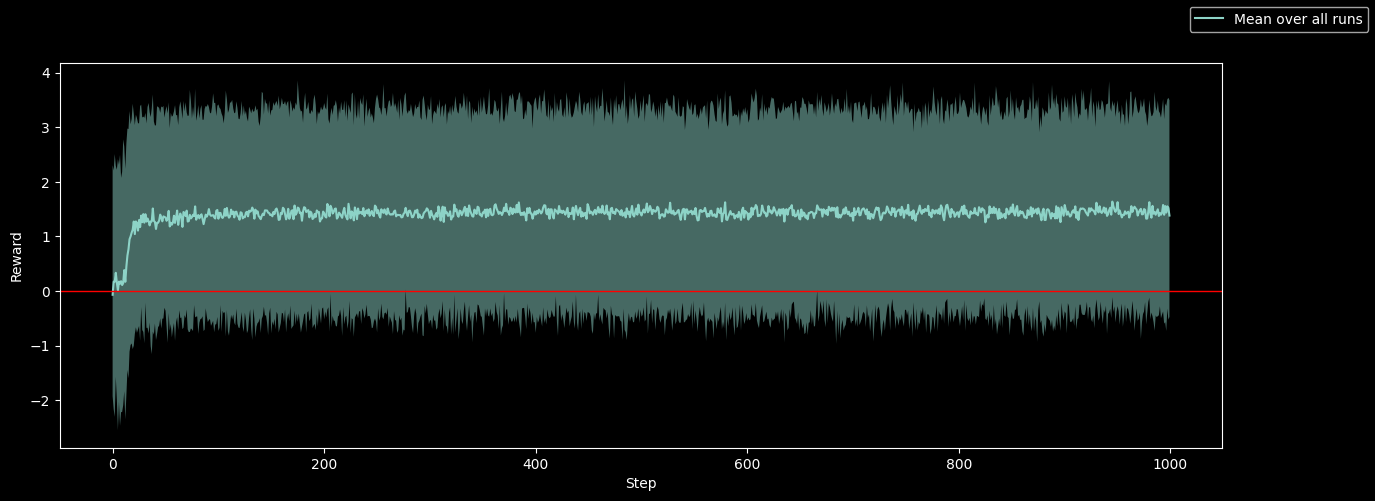

In [239]:
class UCBActionSelection(Agent):
    def __init__(self, num_arms: int, seed: int, c: float):
        self.num_arms = num_arms
        self.seed = seed 
        self.rng = np.random.default_rng(seed)
        self.reward_estimates = [0 for i in range(num_arms)]
        self.actions_taken = [1e-10 for i in range(num_arms)]
        self.k = 1
        self.c = c
        super().__init__(num_arms, seed)

    def get_action(self):
        reward_preferences = self.reward_estimates + self.c*(np.log(self.k)/(self.actions_taken))**0.5
        return np.argmax(reward_preferences)

        
    def observe(self, action, reward, info):
        times_taken_action = self.actions_taken[action]
        self.reward_estimates[action] += (1/times_taken_action)*(reward - self.reward_estimates[action])
        self.actions_taken[action] += 1
        self.k += 1

    def reset(self, seed: int) -> None:
        self.reward_estimates = [0 for i in range(num_arms)]
        self.actions_taken = [1e-10 for i in range(num_arms)]
        self.k = 1
        super().reset(seed)
if MAIN:
    env = gym.make("ArmedBanditTestbed-v0", num_arms=num_arms, stationary=stationary)
    ucb = UCBActionSelection(num_arms, 1, c=1.0)
    (all_rewards, all_corrects) = test_agent(env, ucb, n_runs=N_RUNS)
    print(f"Frequency of correct arm: {all_corrects.mean()}")
    print(f"Average reward: {all_rewards.mean()}")
    plot_rewards(all_rewards)

  0%|          | 0/20 [00:00<?, ?it/s]

Frequency of correct arm: 0.66405
Average reward: 1.3822373582504313


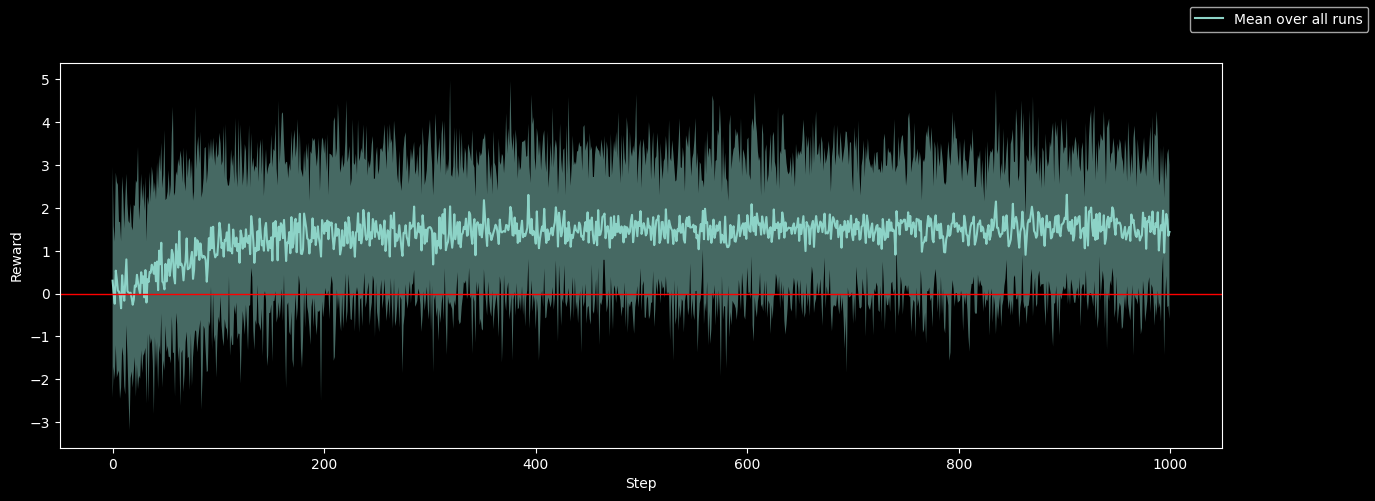

In [244]:
class GradientBandit(Agent):
    def reset(self, seed: int):
        super().reset(seed)
        self.baseline = 0
        self.preferences = np.zeros(num_arms, dtype=np.float64)
        self.probs = np.exp(self.preferences)
        self.probs /= self.probs.sum()
        self.t = 1
        self.preference_history = []
        self.action_history = []
    def __init__(
        self, num_arms: int, seed: int, alpha: float
    ):
        self.alpha = alpha
        super().__init__(num_arms, seed)
        
    def observe(self, action: ActType, reward: float, info: dict) -> None:
        
        
        surplus = reward - self.baseline
        updates = -self.alpha * surplus * self.probs

        updates[action] = (
            self.alpha * surplus * (1 - self.probs[action])
        )

        self.preferences = self.preferences  + updates

        # np.testing.assert_allclose(
        #     self.preferences.sum(), 0, rtol=0, atol=.01, 
        #     err_msg=f'prefs should sum to 0: self.probs={self.probs}, preferences={self.preferences}, updates={updates}, reward={reward}, baseline={self.baseline}'
        # )
        self.probs = np.exp(self.preferences)
        self.probs = self.probs / self.probs.sum()
        # np.testing.assert_allclose(
        #     self.probs.sum(), 1, rtol=0, atol=.01, 
        #     err_msg=f'probs dont sum to 1: self.probs={self.probs}, preferences={self.preferences}'
        # )
        self.baseline += (reward - self.baseline) / self.t
        self.t += 1


        self.preference_history.append(self.preferences)

    def get_action(self) -> ActType:
        action = self.rng.choice(np.arange(self.num_arms), p=self.probs)
        self.action_history.append(action)
        return action


if MAIN:
    num_arms = 10
    stationary = True
    env = gym.make("ArmedBanditTestbed-v0", num_arms=num_arms, stationary=stationary)
    grad_bandit = GradientBandit(num_arms, 0, alpha=0.1)
    (all_rewards, all_corrects) = test_agent(env, grad_bandit, n_runs=20)
    print(f"Frequency of correct arm: {all_corrects.mean()}")
    print(f"Average reward: {all_rewards.mean()}")
    plot_rewards(all_rewards)

In [241]:
import plotly.express as px 
preference_history = np.stack(grad_bandit.preference_history)
print(preference_history.shape)
sf_array = np.exp(preference_history).T/np.exp(preference_history).sum(axis=1)
px.line(sf_array.T, labels={'index': 'time', 'value': 'preference'})


(1000, 10)


/Users/josephbloom/miniforge3/envs/arena/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [243]:
env.arm_reward_means

array([ 0.09712565, -0.15815693,  0.49955607,  0.10796394, -0.12886379,
       -0.10462027, -0.48683608, -0.13190632,  0.61882974, -0.61538978])

In [ ]:
ObsType = int
ActType = int

class ContextualMultiArmedBandit(gym.Env):
    action_space: gym.spaces.Discrete
    observation_space: gym.spaces.Discrete
    num_arms: int
    stationary: bool
    arm_reward_means: np.ndarray
    arm_star: int

    def __init__(self, num_rooms= 3, num_arms=10, stationary=True):
        super().__init__()
        self.num_rooms = num_rooms
        self.num_arms = num_arms
        self.stationary = stationary
        self.observation_space = gym.spaces.Discrete(1)
        self.action_space = gym.spaces.Discrete(num_arms)
        room_logits = self.np_random.randn(num_rooms)
        self.room_probs = np.exp(room_logits)/np.exp(room_logits).sum()
        self.current_room = self.reset()

    def step(self, arm: ActType) -> tuple[ObsType, float, bool, dict]:
        '''
        Note: some documentation references a new style which has (termination, truncation) bools in place of the done bool.
        '''
        assert self.action_space.contains(arm)
        # if not self.stationary:
        #     q_drift = self.np_random.normal(loc=0.0, scale=0.01, size=self.num_arms)
        #     self.arm_reward_means += q_drift
        #     self.best_arm = int(np.argmax(self.arm_reward_means))
        reward = self.np_random.normal(loc=self.arm_reward_means[arm], scale=1.0)
        obs = self.current_room
        done = False
        info = dict(best_arm=self.best_arm)
        return (obs, reward, done, info)

    def reset(
        self, seed: Optional[int] = None, return_info=False, options=None
    ) -> Union[ObsType, tuple[ObsType, dict]]:
        super().reset(seed=seed)
        if self.stationary:
            self.arm_reward_means = self.np_random.normal(loc=0.0, scale=1.0, size=(self.num_rooms,self.num_arms))
        else:
            raise (NotImplementedError)
        
        self.best_arms = int(np.argmax(self.arm_reward_means, axis = -1))
        
        self.sample_room()

        if return_info:
            return (0, dict())
        else:
            return 0
        
        return 
    
    def sample_room(self):
        self.room = self.np_random.choice(self.num_rooms, p=self.room_probs)
    
    def render(self, mode="human"):
        assert mode == "human", f"Mode {mode} not supported!"
        bandit_samples = []
        for arm in range(self.action_space.n):
            bandit_samples += [np.random.normal(loc=self.arm_reward_means[arm], scale=1.0, size=1000)]
        plt.violinplot(bandit_samples, showmeans=True)
        plt.xlabel("Bandit Arm")
        plt.ylabel("Reward Distribution")
        plt.show()

def run_episode(env: gym.Env, agent: Agent, seed: int):
    (rewards, was_best) = ([], [])
    env.reset(seed=seed)
    agent.reset(seed=seed)
    done = False
    while not done:
        room_dist = env.get_room_dist()
        arm = agent.get_action(room_dist)
        (obs, reward, done, info) = env.step(arm)
        agent.observe(arm, reward, info)
        rewards.append(reward)
        was_best.append(1 if arm == info["best_arm"] else 0)
    rewards = np.array(rewards, dtype=float)
    was_best = np.array(was_best, dtype=int)
    return (rewards, was_best)